In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import mysql.connector as conn

import sqlalchemy as sa
from sqlalchemy import create_engine

import json
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
username = None
password = None

with open("../connection.json") as connection_file:
    cf = json.load(connection_file)
    username = cf["user"]
    password = cf["password"]

connection_uri = sa.engine.URL.create(
    drivername="mysql+pymysql",
    username=username,
    password=password,
    host="localhost",
    database="foodaps",
)

cnx = conn.connect(
    host="localhost",
    database="foodaps",
    user=username,
    password=password,
)

In [24]:
def get_query(conn, query_file): 
    """
    Given a query and a connection returns a pandas table. 
    """
    with open(query_file, "r") as f:
        query = f.read()
    return pd.read_sql(query, conn)

enu_weights = {
    "breakfast": 0.16, 
    "lunch": 0.43, 
    "dinner": 0.30, 
    "snack": 0.11
}

def create_enu_table(): 
    """
    Creates a table from two queries to calculate the 
    equivalent nutritional units (ENU) for each person in the
    houshold and aggregates it to the household level. Does 
    not account for guests. 
    """
    ame = get_query(cnx, "../sql/ame.sql")
    enu = get_query(cnx, "../sql/enu.sql")

    enu["tot_snacks"] = enu["tot_snackam"] + enu["tot_snackpm"]
    enu["weekly_enu"] = (enu["tot_brkfst"]*enu_weights["breakfast"] 
        + enu["tot_lunch"]*enu_weights["lunch"] 
        + enu["tot_dinner"]*enu_weights["dinner"] 
        + enu["tot_snacks"]*enu_weights["snack"])

    return ame.merge(enu, left_on=["HHNUM", "PNUM"], right_on=["HHNUM", "PNUM"], how="left").groupby(
        "HHNUM").agg({
            "weekly_enu": "sum",
            "TEE": "sum", 
            "AME": "sum"
        }).reset_index()

enu = create_enu_table()
enu

,HHNUM,weekly_enu,TEE,AME
0,100012,24.92,39.7170,2.888005
1,100015,5.67,6.1830,0.449594
2,100024,12.25,19.3644,1.408074
3,100026,15.43,20.8030,1.512681
4,100028,12.62,47.4014,3.446773
...,...,...,...,...
4821,120049,12.64,5.8180,0.423053
4822,120067,33.84,45.1530,3.283281
4823,120077,3.08,5.0730,0.368881
4824,120078,12.40,12.2076,0.887671


In [41]:
def majority_vote_household_demographic(hh_series):
    """
    If a household comprises of members of the same 
    race, then returns that race. Otherwise, returns
    "mixed".
    """
    if hh_series.unique().shape[0] == 1:
        return hh_series.unique()[0]
    else:
        return "mixed"

def create_household_table():
    indiv = get_query(cnx, "../sql/indiv_char.sql")
    hh = get_query(cnx, "../sql/household_char.sql")

    hh["guest_enu"] = (hh["nguest_brkfst"] * enu_weights["breakfast"] + 
    hh["nguest_lunch"] * enu_weights["lunch"] + 
    hh["nguest_dinner"] * enu_weights["dinner"] + 
    hh["nguest_snack"] * enu_weights["snack"])

    hh_demo = indiv.groupby("hhnum").agg({
        "Race": majority_vote_household_demographic,
        "Hispanic": majority_vote_household_demographic,
        "female_head": "first"}).reset_index()

    return hh.merge(hh_demo, left_on="hhnum", right_on="hhnum", how="left")

hh = create_household_table()
hh

,hhnum,inchhavg_r,snapnowhh,snapever,snap12mos,SNAPLASTAMT,schservebrkfst,wichh,nguest_brkfst,nguest_lunch,...,nguest_snack,northeast,midwest,south,west,nonmetro,guest_enu,Race,Hispanic,female_head
0,100012,4667.33,1,1,1,125,1,-996,0,0,...,2,0,0,1,0,1,0.22,White,Not Hispanic,0
1,100015,1200.00,0,1,0,0,-996,-996,0,0,...,0,0,0,1,0,0,0.00,Black,Not Hispanic,0
2,100024,5024.50,0,1,0,0,1,-996,0,0,...,0,0,1,0,0,0,0.00,White,Not Hispanic,1
3,100026,1800.00,0,1,1,225,-996,-996,0,0,...,0,0,0,1,0,0,0.00,White,Not Hispanic,1
4,100028,3998.00,1,-996,-996,725,0,1,0,0,...,0,1,0,0,0,0,0.00,White,Not Hispanic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4821,120049,2200.00,0,0,-996,0,-996,1,0,0,...,2,0,0,1,0,0,0.22,Black,Not Hispanic,1
4822,120067,2500.00,1,-996,-996,1000,1,0,0,0,...,0,0,0,1,0,0,3.30,White,Not Hispanic,1
4823,120077,1009.00,1,-996,-996,0,-996,-996,0,0,...,0,0,0,1,0,0,0.00,White,Not Hispanic,1
4824,120078,523.60,1,-996,-996,325,1,-996,0,0,...,0,0,0,1,0,1,0.00,Black,Not Hispanic,1


In [46]:
fah_nut = get_query(cnx, "../sql/nutrients.sql")
fah_nut = fah_nut.dropna()

#remove SUM() and hh_ from column names
fah_nut.columns = [col.split("_")[1] if "SUM" in col else col for col in fah_nut.columns]

#remove ) from column names
fah_nut.columns = [col.split(")")[0] if ")" in col else col for col in fah_nut.columns]

#add fah to column_names except for hhnum
fah_nut.columns = ["fah_" + col if col != "hhnum" else col for col in fah_nut.columns]

fah_nut

,hhnum,fah_energy,fah_carb,fah_dietfiber,fah_totsug,fah_totfat,fah_satfat,fah_monofat,fah_polyfat,fah_protein,...,fah_vitarae,fah_vitb6,fah_vitb12,fah_vitc,fah_iron,fah_thiamin,fah_riboflavin,fah_calcium,fah_phosphorus,fah_magnes
0,100381,6846.500527,936.142768,99.027194,617.136943,209.143126,125.806363,57.840535,12.485689,353.102473,...,4423.896854,9.102930,41.532088,573.190582,45.515475,6.000948,16.541625,10055.038807,9292.242430,1950.526362
1,110265,67373.094655,12256.660002,761.200983,5051.812074,1268.373484,305.122374,474.940538,340.742109,1853.434329,...,21246.191844,49.004003,111.192652,2135.788355,582.745888,75.154083,67.426217,23522.928073,34496.221079,10763.760269
2,103790,65111.325211,8155.070881,534.972881,3097.473569,2657.297047,627.512007,977.349319,805.119578,2272.756238,...,13261.985663,58.523761,95.917529,2066.731751,468.953545,46.641786,45.124455,23274.777149,35532.071812,8511.338571
3,103698,5409.723214,856.816374,36.263813,659.604437,180.234540,72.144798,71.422339,25.053374,133.446795,...,2308.977815,3.247560,13.312216,579.676146,10.171817,2.414290,5.131065,3150.634327,3023.625803,539.210670
4,107440,10984.992033,1689.424633,49.598565,850.888782,284.911123,129.755041,83.285330,34.466582,388.274516,...,1764.411614,13.152935,58.250093,188.339682,65.755988,14.298147,11.590094,4209.192941,7619.476939,964.993463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361,118183,1442.416188,104.552494,0.000000,104.552494,114.803628,98.805509,7.330014,2.372276,5.669875,...,31.751300,0.000000,0.000000,0.000000,0.544308,0.000000,0.000000,27.215400,36.287200,9.071800
4363,119982,1905.913828,255.781415,7.779240,128.668631,94.439975,30.276803,24.088417,32.525003,19.720374,...,0.000000,0.225598,0.077792,0.000000,21.315118,1.155217,1.155217,81.682021,431.747826,155.584802
4364,116274,1502.550000,278.170200,15.309000,28.746900,18.087300,3.957660,3.396330,9.083340,51.880500,...,0.000000,0.493290,0.000000,0.000000,20.355300,3.022110,1.377810,1474.200000,584.010000,141.750000
4365,118170,1967.958952,327.509417,9.072000,293.169629,66.912997,41.923981,10.088064,1.229256,24.496207,...,63.504001,0.215460,0.430920,1.134000,4.687879,0.344736,0.167832,241.107621,640.806097,183.708002


3548

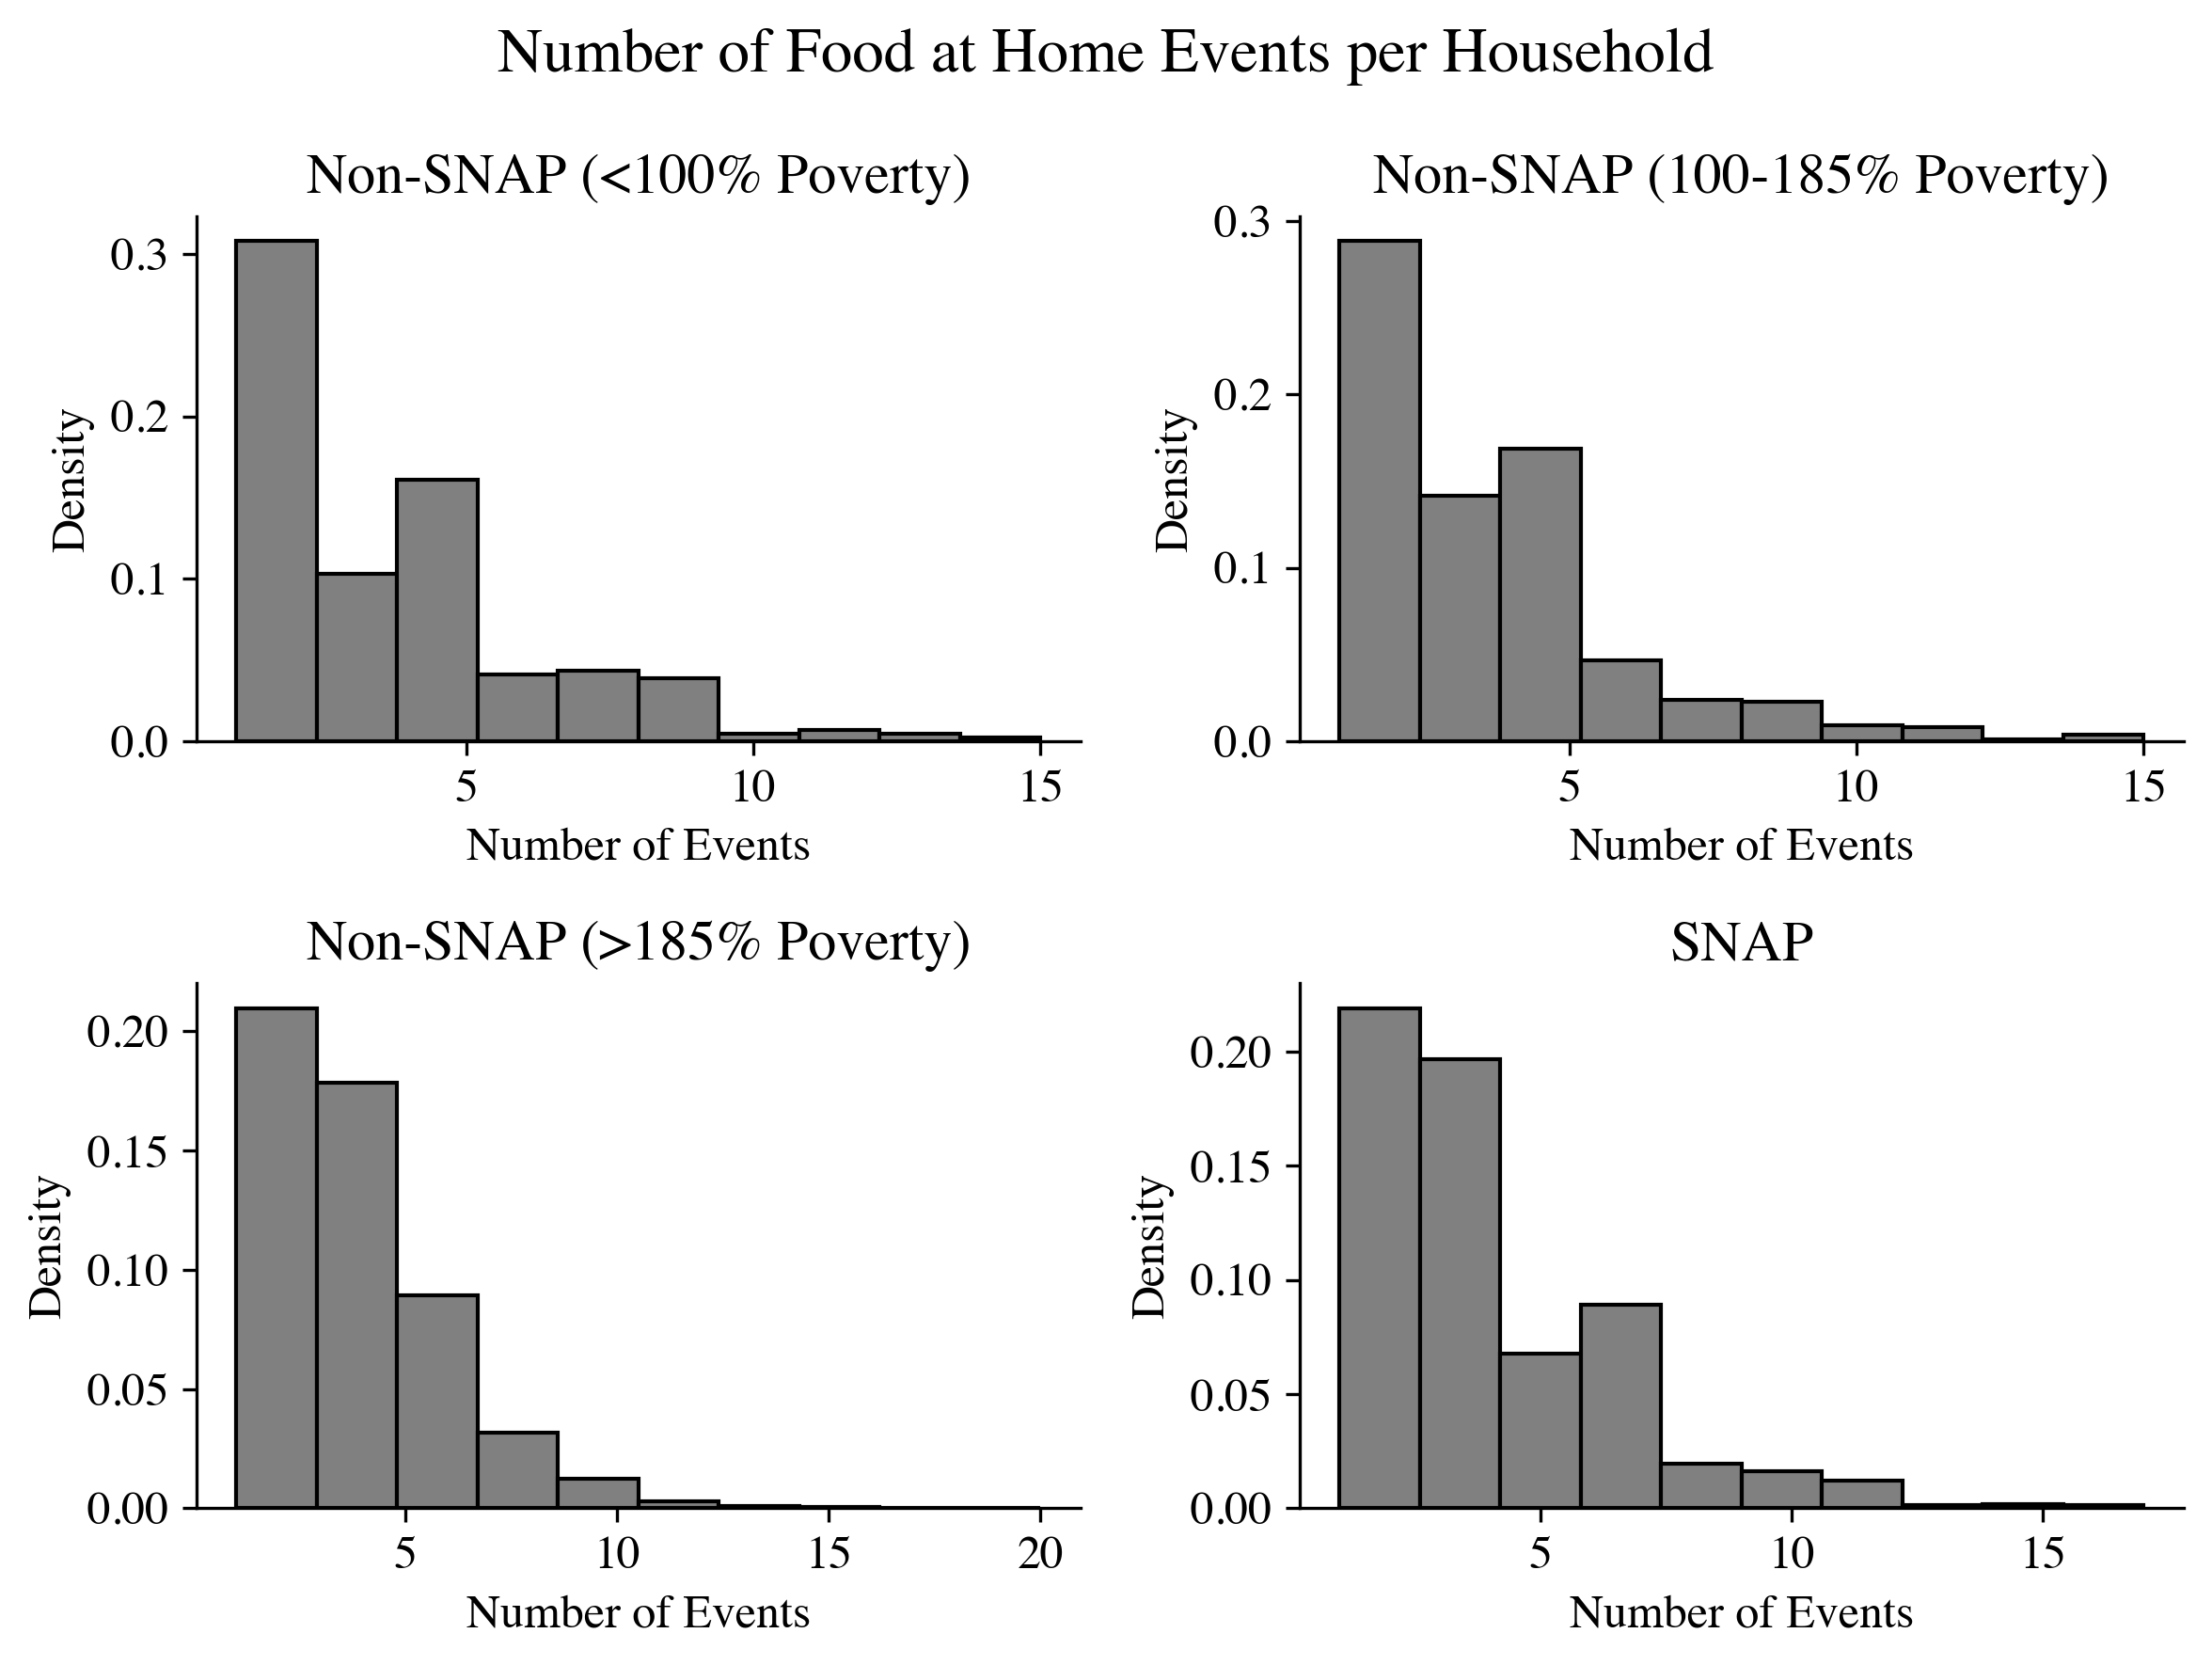

In [52]:
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "times"

fig, axes = plt.subplots(2,2)

group_dict = {
    1: "Non-SNAP (<100% Poverty)",
    2: "Non-SNAP (100-185% Poverty)",
    3: "Non-SNAP (>185% Poverty)",
    4: "SNAP"
}

for i in range(1, 5):
    events = pd.read_sql(num_events.format(targetgroup=i), cnx)
    ax = axes.flatten()[i-1]
    ax.hist(events.num_events, 
        label=f"Target Group {i}",
        color = "grey",
        edgecolor = "black",
        density=True)

    ax.set_xlabel("Number of Events")
    ax.set_ylabel("Density")
    ax.set_title(group_dict[i])
    ax.spines[["right", "top"]].set_visible(False)

fig.suptitle("Number of Food at Home Events per Household", fontsize=16)

plt.tight_layout()
plt.show()

In [21]:
cnx.close()